# Measuring galaxy shapes

***

## Imports
 Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *asdf* for accessing Advanced Scientific Data Format (ASDF) files
- *astropy.table Table* for manipulating tabulated data
- *matplotlib.pyplot* for plotting data
- *webbpsf* to access Roman's point-spread function
- *galsim* to measure source moments

In [31]:
import numpy as np
import asdf
from astropy.table import Table
import matplotlib.pyplot as plt
import webbpsf
import galsim
import gwcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from romanisim.bandpass import get_abflux
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources, deblend_sources
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
import os
os.environ['WEBBPSF_PATH']="/grp/jwst/ote/webbpsf-data"

## Introduction
The main goal of this notebook is to illustrate a typical usage case of Roman images, which is performing shape measurements of astronomical sources. This notebook relies on `ASDF` file manipulations. For additional information about these files
and how to use them, please check our `exploring_ASDF` notebook.

### Defining terms
Be sure to define any terms/common acronyms at the end of your introduction that your audience may not know. If you're using some kind of domain-specific astronomical symbol or unusual mathematical concept, make sure you define it (e.g. in its mathematical form) and link to any definitions (literature/Wikipedia etc.).

***

## Loading data
The first step of the analysis is to read the Roman image data, which are stored in ASDF format. For this example we start with a calibrated level-2 simulated image created with [`romanisim`](https://romanisim.readthedocs.io). For more information about Roman's data products check the [Roman User Documentation](roman-docs.stsci.edu).

In [5]:
# This  will change when the data are elsewhere
img_path = '/grp/roman/SCIENCE_PLATFORM_DATA/ROMANISIM/DENSE_REGION/R0.5_DP0.5_PA0/r0000101001001001001_01101_0001_WFI01_cal.asdf'
img_asdf = asdf.open(img_path)

The idea to perform these measurements is to get image cutouts of the individual sources, and perform our measurements. There are many options to get the cutouts. In this case we rely on information from the input catalog.

In [7]:
img_arr = img_asdf['roman']['data'][:, :].value
#img_err = img_asdf['roman']['err'][:, :].value

In [10]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img_arr[: ,:], kernel)

In [12]:
bkg_estimator = MedianBackground()
bkg = Background2D(img_arr[:, :], (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
img_arr2 = img_arr - bkg.background  

In [13]:
cat_path = '/grp/roman/SCIENCE_PLATFORM_DATA/ROMANISIM/DENSE_REGION/R0.5_DP0.5_PA0/fullcat_101M_pared_ra0.50_dec0.50_WFI01.ecsv'
catalog = Table.read(cat_path, format='ascii.ecsv')

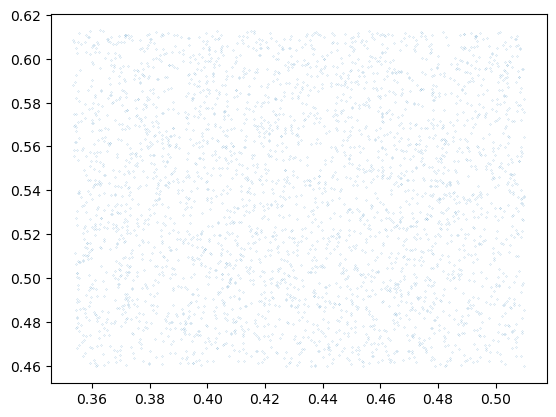

In [14]:
plt.scatter(catalog['ra'][::100], catalog['dec'][::100], s=0.01)

In [15]:
band = img_asdf['roman']['meta']['instrument']['optical_element']
print('The simulated band is:', band)

The simulated band is: F158


In [16]:
w = img_asdf['roman']['meta']['wcs'] # We call the GWCS object w for later usage

In [17]:
coords = SkyCoord(ra=catalog['ra']*u.deg, dec=catalog['dec']*u.deg)  # Save the catalogs' coordinates in a SkyCoord object
x, y = w.world_to_array_index_values(coords)  # Convert from sky to detector indices

In [18]:
x, y = w.world_to_array_index_values(coords)

In [19]:
img_asdf['roman']['meta']['instrument']

{'detector': 'WFI01', 'optical_element': 'F158', 'name': 'WFI'}

In [20]:
ind = (-2.5*np.log10(catalog['F158']) > 21) & (-2.5*np.log10(catalog['F158']) < 21.5) & (catalog['type'] == 'SER')

In [21]:
np.count_nonzero(ind)

562

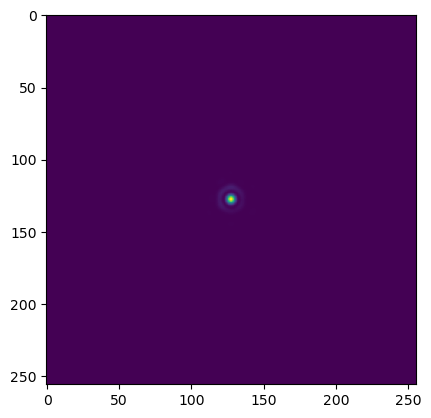

In [22]:
nc = webbpsf.WFI()
nc.filter = band
psf = nc.calc_psf(fov_pixels=64)
psf_img = galsim.Image(psf[0].data, scale=0.1/4)
plt.imshow(psf_img.array)

In [23]:
zp = get_abflux(band)

21.096110343933105 0.21389057


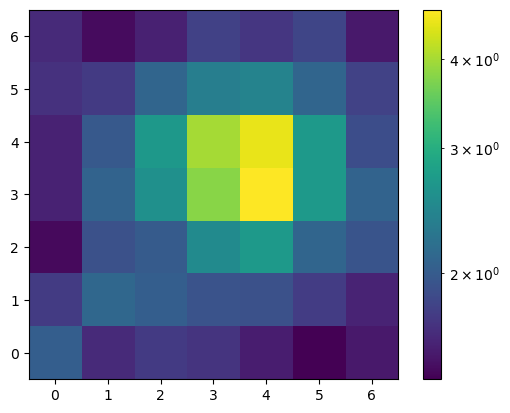

In [24]:
size = 7
igal = 4
cutout = galsim.Image(img_arr[int(x[ind][igal]-size//2):int(x[ind][igal]+size//2+1),
                 int(y[ind][igal]-size//2):int(y[ind][igal]+size//2+1)], scale=0.1)
print(-2.5*np.log10(catalog['F158'][ind][igal]), catalog['half_light_radius'][ind][igal])
from matplotlib.colors import LogNorm
plt.imshow(cutout.array, origin='lower', norm=LogNorm())
plt.colorbar()

In [25]:
cutout.array.shape

(7, 7)

In [26]:
shape = galsim.hsm.EstimateShear(cutout, psf_img, strict=False)

In [27]:
shape

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=7, ymin=1, ymax=7), moments_status=0, observed_shape=galsim.Shear((0.010476233242322754+0.031500388967489745j)), moments_sigma=2.052166700363159, moments_amp=102.20750427246094, moments_rho4=1.8416375699484384, moments_n_iter=18, correction_status=0, corrected_e1=0.17296694219112396, corrected_e2=0.2863459587097168, meas_type='e', corrected_shape_err=0.0, correction_method='REGAUSS', resolution_factor=0.09663635492324829, psf_sigma=1.9522353410720825, psf_shape=galsim.Shear((-0.01244081976968669-0.0015069343548656134j)))

In [28]:
psf_obj = galsim.InterpolatedImage(psf_img, flux=1, scale=0.1/4)

In [51]:
p0 = [catalog['n'][ind][igal], catalog['half_light_radius'][ind][igal], catalog['F158'][ind][igal],
              catalog['pa'][ind][igal], 0., 0., catalog['ba'][ind][igal]]

In [57]:
pout, pcov = curve_fit(sersic_mod, np.zeros_like(cutout.array).flatten(), cutout.array.flatten(),
          p0=p0, bounds=([0.3, 0.05, 1e-11, 0, 0, 0, 0], [6.2, 3.0, 1e-7, 180, 2, 2, 1]))

ValueError: `x0` is infeasible.

In [58]:
pout/p0

NameError: name 'pout' is not defined

In [54]:
def sersic_mod(x, n, hlr, flux, pa, x0, y0, q):
    print(x, n, hlr, flux, pa, x0, y0, q)
    flux = flux*zp
    ser = galsim.Sersic(n, half_light_radius=hlr, flux=flux)
    ser.shear(q=q, beta=pa*galsim.degrees)
    offset = galsim.PositionD(x=x0, y=y0)
    ser = galsim.convolve.Convolve(ser, psf_obj)
    img = galsim.ImageD(size, size)
    ser.drawImage(image=img, offset=offset)
    return img.array.flatten()

In [56]:
model = sersic_mod(np.zeros(1), p0[0], p0[1], p0[2], p0[3], p0[4], p0[5], p0[6])

[0.] 2.497251 0.21389057 3.6438121e-09 273.4392 0.0 0.0 0.82055575


In [ ]:
plt.imshow(cutout.array/model.reshape((size, size)), origin='lower')
plt.colorbar()


In [ ]:
img_asdf['roman'].keys()

In [ ]:
plt.imshow(sersic_mod(np.zeros(1), p0[0], p0[1], p0[2], p0[3], p0[4], p0[5], p0[6]).reshape((size, size)))

## Sections (xN)

The meat of your notebook should be sub-divided into sections with useful names to whatever extent makes sense base on the content. Break sections up with standard Markdown syntax headings:

```
# Section 1

Intro to section 1

### Sub-section 1a

More detailed info about Section 1

## Section 2

A complete thought that's as important as section 1 but doesn't need sub-sections.
```

## Exercises
Most notebooks are trying to convey _some_ information to their reader. It's often a good idea, if possible, to include in the notebook something where there is not an included answer so that the reader can cement in their mind how whatever it is they were supposed to learn from that notebook. If you do have exercise(s), be sure to leave a blank code cell underneath to show the user that it's meant for them to try it out right there. You may also want to include a "solutions" notebook next to your main notebook for the user to look at after they have finished their attempt.

## Aditional Resources
While this isn't always necessary, sometimes you want to provide some more resources for the reader who wants to learn something beyond what's in the notebook. Sometimes these don't exist, but if they do, it's good to put them at the end to give the reader somewhere else to go. Usually a list of links using markdown bullet-plus-link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html)

## About this notebook
Let the world know who the author of this great notebook is! If possible/appropriate, include a contact email address for users who might need support (e.g. archive@stsci.edu)

**Author:** Javier Sánchez, Amethyst Barnes, Ami Choi.  
**Updated On:** YYYY-MM-DD

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 